In [1]:
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import imageio
import os
import re
import copy
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
#import mrc as mrc


Wall time: 5.36 s


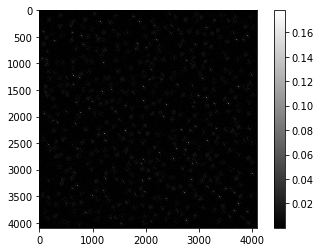

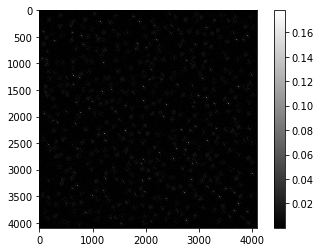

In [3]:
%%time
#Main code, just copy and pasted from other notebook
def normalized_cc(I,T,use_numpy_ver=True):
    T = T - np.mean(T)
    
    # Zero padding the template
    [height,length] = I.shape
    [bheight,blength] = T.shape
    
    x = [height/2-bheight/2]
    y = [length/2-bheight/2]
    x = int(x[0])
    y = int(y[0])
    
    padding = np.zeros_like(I)
    
    # Create mask of zero-padded template
    padding[x:x+int(T.shape[0]), y:y+int(T.shape[1])]=1.0
   

    # Compute correlations of I and I**2
    crossc = fast_convolve(I,T[::-1,::-1],use_numpy_ver)
    denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
    denom2 = np.sqrt(np.sum((T**2)))
    
    # Compute and return normalized cross-correlation
    ncc = crossc/(denom1*denom2)
#     plt.imshow(abs(ncc))
    
    return ncc
    

def fast_convolve(I,T,use_numpy_ver=True):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T

        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(z)

        conv = f1*f2

        fc = np.fft.fftshift(np.fft.irfft2(conv))
        
#         fc = np.roll(fc, -int(height/2+1), axis=0)
#         fc = np.roll(fc, -int(length/2+1), axis=1)
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc

ncc_np = abs(normalized_cc(scipy.misc.imread("mgtest.png", 1),scipy.misc.imread("binnedpart.jpg", 1),use_numpy_ver=True))
#ncc_sp = normalized_cc(scipy.misc.imread("mgtest.png", 1),scipy.misc.imread("binnedpart.jpg", 1),use_numpy_ver=False)
plt.figure()
plt.imshow(ncc_np)
plt.colorbar()
#scipy.misc.imsave('look3.jpg', abs(ncc_np))

plt.figure()
plt.imshow(abs(ncc_np))
plt.colorbar()

# plt.figure()
# plt.imshow(abs(ncc_np - abs(ncc_np)))
# plt.colorbar()


#scipy.misc.imsave('check.jpg', abs(abs(ncc_np)-ncc_np))
#5.1 seconds for the numpy stuff, 11.6 for scipy

In [66]:
%%time
#Version 1 to loop through particles
def normalized_cc(I,T,use_numpy_ver=True):
    T = T - np.mean(T)
    # zero padding the template
    [height,length] = I.shape
    [bheight,blength] = T.shape
    
    x = [height/2-bheight/2]
    y = [length/2-bheight/2]
    x = int(x[0])
    y = int(y[0])
    
    padding = np.zeros_like(I)
    
    # Create mask of zero-padded template
    padding[x:x+int(T.shape[0]), y:y+int(T.shape[1])]=1.0
    
    
    # Compute correlations of I and I**2
    crossc = fast_convolve(I,T[::-1,::-1],use_numpy_ver)
    denom1 = np.sqrt(fast_convolve(I**2, padding,use_numpy_ver))
    denom2 = np.sqrt(np.sum((T**2)))
    
    # Compute and return normalized cross-correlation
    ncc = crossc/(denom1*denom2)
#     plt.imshow(abs(ncc))
    
    return ncc
    

def fast_convolve(I,T,use_numpy_ver=True):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T

        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(z)

        conv = f1*f2

        fc = np.fft.fftshift(np.fft.irfft2(conv))
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc

folder = 'Particles'

for part in os.listdir(folder):
    ncc = abs(normalized_cc(scipy.misc.imread('mgtest2.png',1), scipy.misc.imread(os.path.join(folder, part),1),use_numpy_ver = True))
   # plt.figure()
#     plt.imshow(ncc)
#     plt.colorbar()
    #scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'A.jpg', ncc)

#Numpy ver - 14.4s+-75ms, scipy - 34.6s
    

14.4 s ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%%time
#Version 2 - Trying to reduce FT calls on the image
def multi_particles(I, folder, use_numpy_ver=True):
    
    f1 = np.fft.rfft2(I)
        
    for part in os.listdir(folder):
        zed =  scipy.misc.imread(os.path.join(folder, part),1)

        zed = zed - np.mean(zed)
       
        # zero padding the template
        
        [height,length] = I.shape
        [bheight,blength] = zed.shape

        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        padding = np.zeros_like(I)

        # Create mask of zero-padded template
        padding[x:x+int(zed.shape[0]), y:y+int(zed.shape[1])]=1.0


        # Compute correlations of I and I**2
        crossc = fast_convolve(I,zed[::-1,::-1],use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc = abs(crossc/(denom1*denom2))
#         plt.figure()
#         plt.imshow(ncc)
#         plt.colorbar()
        
        #scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'B.jpg', ncc)
        
    return ncc
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T
        
        if np.any(IFT):
            f2 = np.fft.rfft2(z)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(z)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    
ncc = multi_particles(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)

    
#13.1s+-77ms

13.1 s ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wall time: 13.7 s


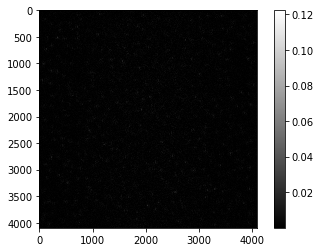

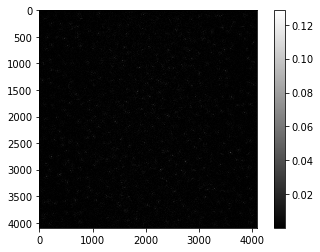

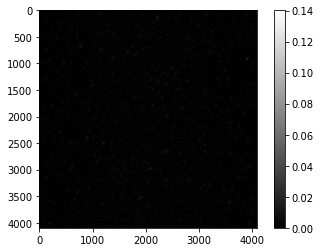

In [2]:
%%time
#Version 3 - Reducing number of blank and masked images created, changed fft convolve
def multi_particles(I, folder, use_numpy_ver=True):
    
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    [Theight,Tlength] = (scipy.misc.imread(os.path.join(folder, os.listdir(folder)[0]))).shape
    [height,length] = I.shape
    
    x = int(height/2-Theight/2)
    y = int(length/2-Tlength/2)
    
    padding[x:x+int(Theight), y:y+int(Tlength)] = 1.0

    
    for part in os.listdir(folder):
        zed =  scipy.misc.imread(os.path.join(folder, part),1)

        zed = zed - np.mean(zed)
       
        mask = copy.copy(padding)
        mask[x:x+int(Theight), y:y+int(Tlength)] = zed[::-1,::-1]
        
        # Compute correlations of I and I**2
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc = abs(crossc/(denom1*denom2))
        
        plt.figure()
        plt.imshow(ncc)
        plt.colorbar()
        #scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'C.jpg', ncc)
    return ncc
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))      
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    
ncc = multi_particles(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)
#time 12.8s+-77ms